In [1]:
from keras.initializers import Initializer
from sklearn.cluster import KMeans

from keras import backend as K
from keras.engine.topology import Layer
from keras.initializers import RandomUniform, Initializer, Constant
import numpy as np

from keras.models import Sequential
from keras.layers import Dense
from keras.losses import binary_crossentropy
from keras.optimizers import Adam

Using TensorFlow backend.


In [2]:
# kmeans layer
class InitCentersKMeans(Initializer):
    """ Initializer for initialization of centers of RBF network
        by clustering the given data set.
    # Arguments
        X: matrix, dataset
    """

    def __init__(self, X, max_iter=100):
        self.X = X
        self.max_iter = max_iter

    def __call__(self, shape, dtype=None):
        assert shape[1] == self.X.shape[1]

        n_centers = shape[0]
        km = KMeans(n_clusters=n_centers, max_iter=self.max_iter, verbose=0)
        km.fit(self.X)
        return km.cluster_centers_

In [3]:
## RBF layer 
class RBFLayer(Layer):
    def __init__(self, output_dim, initializer=None, betas=1.0, **kwargs):
        self.output_dim = output_dim
        self.init_betas = betas
        if not initializer:
            self.initializer = RandomUniform(0.0, 1.0)
        else:
            self.initializer = initializer
        super(RBFLayer, self).__init__(**kwargs)

    def build(self, input_shape):

        self.centers = self.add_weight(name='centers',
                                       shape=(self.output_dim, input_shape[1]),
                                       initializer=self.initializer,
                                       trainable=True)
        self.betas = self.add_weight(name='betas',
                                     shape=(self.output_dim,),
                                     initializer=Constant(
                                         value=self.init_betas),
                                     trainable=True)

        super(RBFLayer, self).build(input_shape)

    def call(self, x):
        C = K.expand_dims(self.centers)
        H = K.transpose(C-K.transpose(x))
        return K.exp(-self.betas * K.sum(H**2, axis=1))

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.output_dim)

    def get_config(self):
        # have to define get_config to be able to use model_from_json
        config = {
            'output_dim': self.output_dim
        }
        base_config = super(RBFLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

## 生成数据

In [4]:
## create dataset
# reference https://zhuanlan.zhihu.com/p/36982945
def test_data(sample_number = 1000):
    #随机从高斯分布中生成两个数据集
    mean0=[2,7]
    cov=np.mat([[1,0],[0,2]])
    data1=np.random.multivariate_normal(mean0,cov,sample_number)

    mean1=[6,3]
    cov=np.mat([[1,0],[0,2]])
    data2=np.random.multivariate_normal(mean1,cov,sample_number)
    
    y1 = np.zeros((sample_number,1))#第一类，标签为0
    y2 = np.ones((sample_number,1))#第二类类，标签为1
    
    train_data = np.vstack((data1,data2))
    train_label = np.vstack((y1,y2))
    
    shuffle_idx = np.arange(sample_number*2)
    np.random.shuffle(shuffle_idx)
    
    train_data = train_data[shuffle_idx]
    train_label = train_label[shuffle_idx]
    return train_data,train_label

In [5]:
samples_num = 1000
train_data,train_label = test_data(samples_num)

## 生成模型

In [6]:
model = Sequential()
rbflayer = RBFLayer(10,
                    initializer=InitCentersKMeans(train_data),
                    betas=2.0,
                    input_shape=(2,))
model.add(rbflayer)
model.add(Dense(1))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [7]:
model.compile(loss=binary_crossentropy,optimizer=Adam(),metrics=['accuracy'])

In [8]:
model.fit(train_data,train_label,epochs=1000)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/1000
2000/2000 [==============================] - 1s 279us/step - loss: 1.7195 - accuracy: 0.4920
Epoch 2/1000
2000/2000 [==============================] - 0s 85us/step - loss: 1.0711 - accuracy: 0.5030
Epoch 3/1000
2000/2000 [==============================] - 0s 102us/step - loss: 0.8775 - accuracy: 0.5180
Epoch 4/1000
2000/2000 [==============================] - 0s 115us/step - loss: 0.7999 - accuracy: 0.5320
Epoch 5/1000
2000/2000 [==============================] - 0s 98us/step - loss: 0.7334 - accuracy: 0.5595
Epoch 6/1000
2000/2000 [==============================] - 0s 108us/step - loss: 0.6743 - accuracy: 0.5930
Epoch 7/1000
2000/2000 [==============================] - 0s 138us/step - loss: 0.6202 - accuracy: 0.6330
Epoch 8/1000
2000/2000 [==============================] - 0s 99us/step - loss: 0.5700 - accuracy: 0.6630
Epoch 9/1000
2000/2000 [==============================] - 0s

2000/2000 [==============================] - 0s 80us/step - loss: 0.0462 - accuracy: 0.2640
Epoch 74/1000
2000/2000 [==============================] - 0s 64us/step - loss: 0.0460 - accuracy: 0.2585
Epoch 75/1000
2000/2000 [==============================] - 0s 68us/step - loss: 0.0458 - accuracy: 0.2555
Epoch 76/1000
2000/2000 [==============================] - 0s 67us/step - loss: 0.0457 - accuracy: 0.2470
Epoch 77/1000
2000/2000 [==============================] - 0s 67us/step - loss: 0.0459 - accuracy: 0.2415
Epoch 78/1000
2000/2000 [==============================] - 0s 66us/step - loss: 0.0454 - accuracy: 0.2430
Epoch 79/1000
2000/2000 [==============================] - 0s 67us/step - loss: 0.0457 - accuracy: 0.2345
Epoch 80/1000
2000/2000 [==============================] - 0s 72us/step - loss: 0.0457 - accuracy: 0.2510
Epoch 81/1000
2000/2000 [==============================] - 0s 69us/step - loss: 0.0453 - accuracy: 0.2365
Epoch 82/1000
2000/2000 [==============================] - 0

Epoch 150/1000
2000/2000 [==============================] - 0s 64us/step - loss: 0.0457 - accuracy: 0.1490
Epoch 151/1000
2000/2000 [==============================] - 0s 69us/step - loss: 0.0457 - accuracy: 0.1500 0s - loss: 0.0521 - accuracy: 0.
Epoch 152/1000
2000/2000 [==============================] - 0s 62us/step - loss: 0.0457 - accuracy: 0.1505
Epoch 153/1000
2000/2000 [==============================] - 0s 62us/step - loss: 0.0457 - accuracy: 0.1500
Epoch 154/1000
2000/2000 [==============================] - 0s 66us/step - loss: 0.0456 - accuracy: 0.1475
Epoch 155/1000
2000/2000 [==============================] - 0s 70us/step - loss: 0.0458 - accuracy: 0.1470
Epoch 156/1000
2000/2000 [==============================] - 0s 66us/step - loss: 0.0457 - accuracy: 0.1465
Epoch 157/1000
2000/2000 [==============================] - 0s 64us/step - loss: 0.0456 - accuracy: 0.1445
Epoch 158/1000
2000/2000 [==============================] - 0s 73us/step - loss: 0.0456 - accuracy: 0.1450
Epoc

2000/2000 [==============================] - 0s 71us/step - loss: 0.0438 - accuracy: 0.1080
Epoch 226/1000
2000/2000 [==============================] - 0s 98us/step - loss: 0.0435 - accuracy: 0.1055
Epoch 227/1000
2000/2000 [==============================] - 0s 68us/step - loss: 0.0435 - accuracy: 0.1090
Epoch 228/1000
2000/2000 [==============================] - 0s 66us/step - loss: 0.0433 - accuracy: 0.1080
Epoch 229/1000
2000/2000 [==============================] - 0s 64us/step - loss: 0.0435 - accuracy: 0.1075
Epoch 230/1000
2000/2000 [==============================] - 0s 92us/step - loss: 0.0436 - accuracy: 0.1090
Epoch 231/1000
2000/2000 [==============================] - 0s 90us/step - loss: 0.0433 - accuracy: 0.1045
Epoch 232/1000
2000/2000 [==============================] - 0s 80us/step - loss: 0.0432 - accuracy: 0.1055
Epoch 233/1000
2000/2000 [==============================] - 0s 107us/step - loss: 0.0433 - accuracy: 0.1015
Epoch 234/1000
2000/2000 [=========================

2000/2000 [==============================] - 0s 63us/step - loss: 0.0422 - accuracy: 0.1205
Epoch 302/1000
2000/2000 [==============================] - 0s 65us/step - loss: 0.0421 - accuracy: 0.1210
Epoch 303/1000
2000/2000 [==============================] - 0s 72us/step - loss: 0.0421 - accuracy: 0.1195
Epoch 304/1000
2000/2000 [==============================] - 0s 71us/step - loss: 0.0424 - accuracy: 0.1250
Epoch 305/1000
2000/2000 [==============================] - 0s 114us/step - loss: 0.0422 - accuracy: 0.1215
Epoch 306/1000
2000/2000 [==============================] - 0s 85us/step - loss: 0.0422 - accuracy: 0.1260
Epoch 307/1000
2000/2000 [==============================] - 0s 63us/step - loss: 0.0421 - accuracy: 0.1305
Epoch 308/1000
2000/2000 [==============================] - 0s 66us/step - loss: 0.0426 - accuracy: 0.1250
Epoch 309/1000
2000/2000 [==============================] - 0s 66us/step - loss: 0.0421 - accuracy: 0.1255
Epoch 310/1000
2000/2000 [=========================

2000/2000 [==============================] - 0s 76us/step - loss: 0.0416 - accuracy: 0.1630
Epoch 378/1000
2000/2000 [==============================] - 0s 77us/step - loss: 0.0416 - accuracy: 0.1690
Epoch 379/1000
2000/2000 [==============================] - 0s 77us/step - loss: 0.0416 - accuracy: 0.1670
Epoch 380/1000
2000/2000 [==============================] - 0s 64us/step - loss: 0.0415 - accuracy: 0.1720
Epoch 381/1000
2000/2000 [==============================] - 0s 67us/step - loss: 0.0417 - accuracy: 0.1565
Epoch 382/1000
2000/2000 [==============================] - 0s 67us/step - loss: 0.0416 - accuracy: 0.1730
Epoch 383/1000
2000/2000 [==============================] - 0s 75us/step - loss: 0.0416 - accuracy: 0.1660
Epoch 384/1000
2000/2000 [==============================] - 0s 72us/step - loss: 0.0415 - accuracy: 0.1690
Epoch 385/1000
2000/2000 [==============================] - 0s 72us/step - loss: 0.0415 - accuracy: 0.1720
Epoch 386/1000
2000/2000 [==========================

2000/2000 [==============================] - 0s 72us/step - loss: 0.0411 - accuracy: 0.1685
Epoch 454/1000
2000/2000 [==============================] - 0s 70us/step - loss: 0.0414 - accuracy: 0.1675
Epoch 455/1000
2000/2000 [==============================] - 0s 65us/step - loss: 0.0413 - accuracy: 0.1680
Epoch 456/1000
2000/2000 [==============================] - 0s 68us/step - loss: 0.0415 - accuracy: 0.1660
Epoch 457/1000
2000/2000 [==============================] - 0s 64us/step - loss: 0.0412 - accuracy: 0.1685
Epoch 458/1000
2000/2000 [==============================] - 0s 68us/step - loss: 0.0413 - accuracy: 0.1715
Epoch 459/1000
2000/2000 [==============================] - 0s 62us/step - loss: 0.0413 - accuracy: 0.1585
Epoch 460/1000
2000/2000 [==============================] - 0s 64us/step - loss: 0.0415 - accuracy: 0.1590
Epoch 461/1000
2000/2000 [==============================] - 0s 70us/step - loss: 0.0413 - accuracy: 0.1725
Epoch 462/1000
2000/2000 [==========================

2000/2000 [==============================] - 0s 69us/step - loss: 0.0410 - accuracy: 0.1665
Epoch 530/1000
2000/2000 [==============================] - 0s 66us/step - loss: 0.0411 - accuracy: 0.1530
Epoch 531/1000
2000/2000 [==============================] - 0s 67us/step - loss: 0.0410 - accuracy: 0.1740
Epoch 532/1000
2000/2000 [==============================] - 0s 62us/step - loss: 0.0410 - accuracy: 0.1600
Epoch 533/1000
2000/2000 [==============================] - 0s 65us/step - loss: 0.0411 - accuracy: 0.1640
Epoch 534/1000
2000/2000 [==============================] - 0s 63us/step - loss: 0.0410 - accuracy: 0.1695
Epoch 535/1000
2000/2000 [==============================] - 0s 68us/step - loss: 0.0411 - accuracy: 0.1585
Epoch 536/1000
2000/2000 [==============================] - 0s 63us/step - loss: 0.0411 - accuracy: 0.1660
Epoch 537/1000
2000/2000 [==============================] - 0s 73us/step - loss: 0.0409 - accuracy: 0.1745
Epoch 538/1000
2000/2000 [==========================

2000/2000 [==============================] - 0s 67us/step - loss: 0.0409 - accuracy: 0.1725
Epoch 606/1000
2000/2000 [==============================] - 0s 64us/step - loss: 0.0410 - accuracy: 0.1790
Epoch 607/1000
2000/2000 [==============================] - 0s 63us/step - loss: 0.0410 - accuracy: 0.1835
Epoch 608/1000
2000/2000 [==============================] - 0s 63us/step - loss: 0.0409 - accuracy: 0.1765
Epoch 609/1000
2000/2000 [==============================] - 0s 66us/step - loss: 0.0407 - accuracy: 0.1735
Epoch 610/1000
2000/2000 [==============================] - 0s 64us/step - loss: 0.0408 - accuracy: 0.1735
Epoch 611/1000
2000/2000 [==============================] - 0s 64us/step - loss: 0.0408 - accuracy: 0.1785
Epoch 612/1000
2000/2000 [==============================] - 0s 64us/step - loss: 0.0407 - accuracy: 0.1785
Epoch 613/1000
2000/2000 [==============================] - 0s 70us/step - loss: 0.0408 - accuracy: 0.1835
Epoch 614/1000
2000/2000 [==========================

2000/2000 [==============================] - 0s 65us/step - loss: 0.0406 - accuracy: 0.2145
Epoch 682/1000
2000/2000 [==============================] - 0s 64us/step - loss: 0.0406 - accuracy: 0.2250
Epoch 683/1000
2000/2000 [==============================] - 0s 66us/step - loss: 0.0405 - accuracy: 0.2225
Epoch 684/1000
2000/2000 [==============================] - 0s 63us/step - loss: 0.0405 - accuracy: 0.2350
Epoch 685/1000
2000/2000 [==============================] - 0s 66us/step - loss: 0.0405 - accuracy: 0.2230
Epoch 686/1000
2000/2000 [==============================] - 0s 67us/step - loss: 0.0405 - accuracy: 0.2400
Epoch 687/1000
2000/2000 [==============================] - 0s 64us/step - loss: 0.0408 - accuracy: 0.2510
Epoch 688/1000
2000/2000 [==============================] - 0s 65us/step - loss: 0.0406 - accuracy: 0.2245
Epoch 689/1000
2000/2000 [==============================] - 0s 68us/step - loss: 0.0406 - accuracy: 0.2625
Epoch 690/1000
2000/2000 [==========================

Epoch 757/1000
2000/2000 [==============================] - 0s 65us/step - loss: 0.0404 - accuracy: 0.2880
Epoch 758/1000
2000/2000 [==============================] - 0s 68us/step - loss: 0.0403 - accuracy: 0.2740
Epoch 759/1000
2000/2000 [==============================] - 0s 63us/step - loss: 0.0403 - accuracy: 0.2835
Epoch 760/1000
2000/2000 [==============================] - 0s 63us/step - loss: 0.0403 - accuracy: 0.2810
Epoch 761/1000
2000/2000 [==============================] - 0s 66us/step - loss: 0.0403 - accuracy: 0.2915
Epoch 762/1000
2000/2000 [==============================] - 0s 63us/step - loss: 0.0404 - accuracy: 0.3010
Epoch 763/1000
2000/2000 [==============================] - 0s 65us/step - loss: 0.0404 - accuracy: 0.2790
Epoch 764/1000
2000/2000 [==============================] - 0s 74us/step - loss: 0.0404 - accuracy: 0.2760
Epoch 765/1000
2000/2000 [==============================] - 0s 64us/step - loss: 0.0405 - accuracy: 0.2970
Epoch 766/1000
2000/2000 [===========

2000/2000 [==============================] - 0s 65us/step - loss: 0.0403 - accuracy: 0.2700
Epoch 834/1000
2000/2000 [==============================] - 0s 68us/step - loss: 0.0401 - accuracy: 0.2870
Epoch 835/1000
2000/2000 [==============================] - 0s 66us/step - loss: 0.0401 - accuracy: 0.2680
Epoch 836/1000
2000/2000 [==============================] - 0s 116us/step - loss: 0.0401 - accuracy: 0.2585
Epoch 837/1000
2000/2000 [==============================] - 0s 64us/step - loss: 0.0404 - accuracy: 0.2460
Epoch 838/1000
2000/2000 [==============================] - 0s 71us/step - loss: 0.0400 - accuracy: 0.2795
Epoch 839/1000
2000/2000 [==============================] - 0s 71us/step - loss: 0.0401 - accuracy: 0.2730
Epoch 840/1000
2000/2000 [==============================] - 0s 67us/step - loss: 0.0401 - accuracy: 0.2635
Epoch 841/1000
2000/2000 [==============================] - 0s 65us/step - loss: 0.0402 - accuracy: 0.2650
Epoch 842/1000
2000/2000 [=========================

2000/2000 [==============================] - 0s 65us/step - loss: 0.0401 - accuracy: 0.2685
Epoch 909/1000
2000/2000 [==============================] - 0s 65us/step - loss: 0.0400 - accuracy: 0.2780
Epoch 910/1000
2000/2000 [==============================] - 0s 64us/step - loss: 0.0402 - accuracy: 0.2615
Epoch 911/1000
2000/2000 [==============================] - 0s 64us/step - loss: 0.0400 - accuracy: 0.2815
Epoch 912/1000
2000/2000 [==============================] - 0s 64us/step - loss: 0.0400 - accuracy: 0.2575
Epoch 913/1000
2000/2000 [==============================] - 0s 65us/step - loss: 0.0399 - accuracy: 0.2605
Epoch 914/1000
2000/2000 [==============================] - 0s 66us/step - loss: 0.0399 - accuracy: 0.2685
Epoch 915/1000
2000/2000 [==============================] - 0s 64us/step - loss: 0.0399 - accuracy: 0.2755
Epoch 916/1000
2000/2000 [==============================] - 0s 77us/step - loss: 0.0399 - accuracy: 0.2695
Epoch 917/1000
2000/2000 [==========================

2000/2000 [==============================] - 0s 64us/step - loss: 0.0400 - accuracy: 0.2745
Epoch 985/1000
2000/2000 [==============================] - 0s 65us/step - loss: 0.0398 - accuracy: 0.2905
Epoch 986/1000
2000/2000 [==============================] - 0s 64us/step - loss: 0.0399 - accuracy: 0.2740
Epoch 987/1000
2000/2000 [==============================] - 0s 64us/step - loss: 0.0398 - accuracy: 0.2785
Epoch 988/1000
2000/2000 [==============================] - 0s 66us/step - loss: 0.0399 - accuracy: 0.2470
Epoch 989/1000
2000/2000 [==============================] - 0s 73us/step - loss: 0.0398 - accuracy: 0.2750
Epoch 990/1000
2000/2000 [==============================] - 0s 68us/step - loss: 0.0399 - accuracy: 0.2630
Epoch 991/1000
2000/2000 [==============================] - 0s 71us/step - loss: 0.0399 - accuracy: 0.2770
Epoch 992/1000
2000/2000 [==============================] - 0s 67us/step - loss: 0.0398 - accuracy: 0.2845
Epoch 993/1000
2000/2000 [==========================

## draw test model

In [9]:
import matplotlib.pyplot as plt

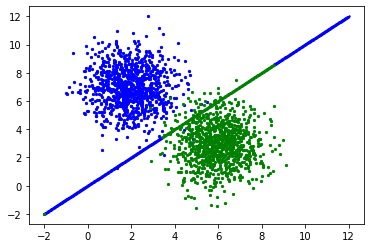

In [10]:
x1 = np.linspace(-2,12,1000)
x2 = np.linspace(12,-2,1000)
test_x = np.vstack((x1,x2)).T

test_y = model.predict(test_x)

# plot the train data
plt.scatter(train_data[np.argwhere(train_label==0),0],train_data[np.argwhere(train_label==0),1],s=5,c='b')
plt.scatter(train_data[np.argwhere(train_label==1),0],train_data[np.argwhere(train_label==1),1],s=5,c='g')
#plot line
plt.scatter(test_x[np.argwhere(test_y<0.5),0],test_x[np.argwhere(test_y<0.5),1],s=2,c='b')
plt.scatter(test_x[np.argwhere(test_y>=0.5),0],test_x[np.argwhere(test_y>=0.5),1],s=2,c='g')